# Homework 1. Making Your First Neural Network: Part 6.
# Important notes:
1. Do not change the name of the network or change the network constructor to take arguments. This will break the autograder.
2. Only changes to areas of the code marked "**modify me**" will be graded. You may not change function signatures or return values from these functions or you will fail the tests.
# Part 0: Initial setup

To enable GPU:
1.   Click Edit -> Notebook settings
2.   Under Runtime type select Python 3
3.   Under Hardware Accelerator select GPU
4.   On the right side of this page, click connect to a hosted runtime


If you ever see an error about needing third-party cookies enabled, you can disable blocking them or whitelist them.
Here is a simple way to whitelist (in Chrome)

For Chrome:
1.   Go to settings and search "content settings"
2.   Click the "content settings" button
3.   Click "Cookies"
4.   Uncheck "Block third-party cookies" or
5.   Click Add next to Allow and type https://[*.]googleusercontent.com:443

In [1]:
# This shows how to connect your google drive account with a colab instance. It's pretty easy.
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/gdrive')
# Create a directory and mount Google Drive using that directory.

# Now let's test that Google Drive is up and running. 
# You may have to change "My Drive" if you have renamed it something else.
!ls "/gdrive/My Drive"

!echo "Hello Google Drive" > "/gdrive/My Drive/foo.txt"
!cat "/gdrive/My Drive/foo.txt"
!rm "/gdrive/My Drive/foo.txt"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
'Colab Notebooks'  'Final Comp_1.mp4'   Untitled0.ipynb
 dl-hw0-master	    RCTA.zip
Hello Google Drive


# Drive not connecting after it seemed like it worked before?
1. First try restarting the runtime via Runtime -> Restart Runtime
2. Then try to run the above again.
3. If this still doesn't work, call Reset All Runtimes. This is the nuclear option that will delete all your data not saved on your personal drive account, and will erase everything you installed.


In [2]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.1.0
# CUDA enabled: True

Version 1.2.0
CUDA enabled: True


In [0]:
# Define some useful save and restoring functions. 
# You can thank your TAs for providing this code, 
# it will probably be useful for you in the future as well.
import torch
import torch.nn as nn
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

class pt_util(object):
    # This does more than the simple Pytorch restore. It checks that the names 
    # of variables match, and if they don't doesn't throw a fit. It is similar 
    # to how Caffe acts. This is especially useful if you decide to change your
    # network architecture but don't want to retrain from scratch.
    @staticmethod
    def restore(net, save_file):
        net_state_dict = net.state_dict()
        restore_state_dict = torch.load(save_file)

        restored_var_names = set()

        print('Restoring:')
        for var_name in restore_state_dict.keys():
            if var_name in net_state_dict:
                var_size = net_state_dict[var_name].size()
                restore_size = restore_state_dict[var_name].size()
                if var_size != restore_size:
                    print('Shape mismatch for var', var_name, 'expected', var_size, 'got', restore_size)
                else:
                    if isinstance(net_state_dict[var_name], torch.nn.Parameter):
                        # backwards compatibility for serialized parameters
                        net_state_dict[var_name] = restore_state_dict[var_name].data
                    try:
                        net_state_dict[var_name].copy_(restore_state_dict[var_name])
                        print(str(var_name) + ' -> \t' + str(var_size) + ' = ' + str(int(np.prod(var_size) * 4 / 10**6)) + 'MB')
                        restored_var_names.add(var_name)
                    except:
                        print('While copying the parameter named {}, whose dimensions in the model are'
                              ' {} and whose dimensions in the checkpoint are {}, ...'.format(
                                  var_name, var_size, restore_size))
                        raise

        ignored_var_names = sorted(list(set(restore_state_dict.keys()) - restored_var_names))
        unset_var_names = sorted(list(set(net_state_dict.keys()) - restored_var_names))
        print('')
        if len(ignored_var_names) == 0:
            print('Restored all variables')
        else:
            print('Did not restore:\n\t' + '\n\t'.join(ignored_var_names))
        if len(unset_var_names) == 0:
            print('No new variables')
        else:
            print('Initialized but did not modify:\n\t' + '\n\t'.join(unset_var_names))

        print('Restored %s' % save_file)
        
    # Restores the last saved network in a folder using file write time.
    @staticmethod
    def restore_latest(net, folder):
        checkpoints = sorted(glob.glob(folder + '/*.pt'), key=os.path.getmtime)
        start_it = 0
        if len(checkpoints) > 0:
            pt_util.restore(net, checkpoints[-1])
            start_it = int(re.findall(r'\d+', checkpoints[-1])[-1])
        return start_it

    # Saves the network and optionally deletes old save files. 
    # If num_to_keep is 0, it won't remove any.
    @staticmethod
    def save(net, file_name, num_to_keep=1):
        folder = os.path.dirname(file_name)
        if not os.path.exists(folder):
            os.makedirs(folder)
        torch.save(net.state_dict(), file_name)
        extension = os.path.splitext(file_name)[1]
        checkpoints = sorted(glob.glob(folder + '/*' + extension), key=os.path.getmtime)
        print('Saved %s\n' % file_name)
        if num_to_keep > 0:
            for ff in checkpoints[:-num_to_keep]:
                os.remove(ff)
                
    # Shows some tiled images.
    @staticmethod
    def show_images(images, titles=None, columns=5, max_rows=5):
        images = images[:min(len(images), max_rows * columns)]

        plt.figure(figsize=(20, 10))
        for ii, image in enumerate(images):
            plt.subplot(len(images) / columns + 1, columns, ii + 1)
            plt.axis('off')
            if titles is not None and ii < len(titles):
                plt.title(str(titles[ii]))
            plt.imshow(image)
        plt.show()

    @staticmethod
    def to_numpy(array):
        if isinstance(array, torch.Tensor):
            return array.detach().cpu().numpy()
        elif isinstance(array, dict):
            return {key: pt_util.to_numpy(val) for key, val in array.items()}
        else:
            return np.asarray(array)

    @staticmethod
    def from_numpy(np_array):
        if isinstance(np_array, list):
            try:
                np_array = np.stack(np_array, 0)
            except ValueError:
                np_array = np.stack([from_numpy(val) for val in np_array], 0)
        elif isinstance(np_array, dict):
            return {key: from_numpy(val) for key, val in np_array.items()}
        np_array = np.asarray(np_array)
        if np_array.dtype == np.uint32:
            print("numpy -> torch dtype uint32 not supported, using int32")
            np_array = np_array.astype(np.int32)
        elif np_array.dtype == np.dtype("O"):
            print("numpy -> torch dtype Object not supported, returning numpy array")
            return np_array
        elif np_array.dtype.type == np.str_:
            print("numpy -> torch dtype numpy.str_ not supported, returning numpy array")
            return np_array
        return torch.from_numpy(np_array)


# Part 1: Implementing a network for MNIST
# 1.1
We would like you to implement a simple network for MNIST. 

MNIST data is 28x28, so the first thing you will need to do is reshape the data to be one long vector.

Your basic network layers will go in the `__init__` function, and the forward call will pass the data through.

For some sample code, look at https://github.com/pytorch/examples/blob/master/mnist/main.py

Additionally, fill in the loss function for the network.

# 1.2
Call the forward and backward passes (again, see https://github.com/pytorch/examples/blob/master/mnist/main.py) in the train and test functions.

# Helpful functions
- https://pytorch.org/docs/stable/tensors.html
- https://pytorch.org/docs/stable/nn.html
- You can call `pt_util.to_numpy(x)` to get a numpy array from a torch tensor x.
- `pt_util.from_numpy(x)` makes a torch Tensor from the numpy array x.

# Common Oopsies
- __Q__ It only runs for one iteration and says it's done: __A__ We provided code that automatically loads the most recent file. If you don't want to start from that checkpoint, simply find it in your google drive and delete it.
- __Q__ I want to save more than just the last checkpoint: __A__ You can change the save function to save any number of previous checkpoints. You can also tell it to save all of them (not delete anything), by passing in 0.
- __Q__ Pytorch is saying things are the wrong shape: __A__ You can easily reshape things using the `view` function (https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view). It is like the Numpy `reshape` function.
- __Q__ Pytorch is saying things are on the wrong device: __A__ You can move data between devices with the `.to(device)` call. Generally, all arguments to a function will need to be on the same device.

In [0]:
# This is where you define your network architecture.
# Note: The TAs know this follows the PyTorch MNIST tutorial available at 
# https://github.com/pytorch/examples/blob/master/mnist/main.py
# Where do you think we got it from? 
# So we are asking you to implement something slightly different. 
# You can use that as a guide, but make sure you understand what it all does.

import tqdm
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
class MNISTNet(nn.Module):
    def __init__(self):
        # modify me
        super(MNISTNet, self).__init__()
        # The network should be as follows:
        # One fully connected layer with 1024 outputs.
        self.fc1 = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU()
        )
        # One fully connected layer with 512 outputs.
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        # Then the final classification layer.
        self.fc3 = nn.Linear(512, 10)
        # All the nonlinearities should be ReLU.
        # raise NotImplementedError('Define the layers here')
    def forward(self, x):
        # modify me
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
        # raise NotImplementedError('Define the forward pass')
      
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    # prediction and label should be PyTorch Tensors.
    # You should return the result from the Cross Entropy function.
    # You should also use the cross_entropy loss rather than the NLL loss.
    def loss(self, prediction, label, reduction='mean'):
        # modify me
        loss_fn = nn.CrossEntropyLoss(reduction=reduction)
        lossoutput = loss_fn(prediction, label)
        return lossoutput
        # raise NotImplementedError('Define the loss here')

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

def train_step(model, data, label, optimizer):
    # modify me
    output = model(data)
    loss = model.loss(output, label)
    loss.backward()
    # raise NotImplementedError('Call the forward pass, loss, and backward here.')
    return loss

def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        loss = train_step(model, data, label, optimizer)        
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test_step(model, data, label):
    # modify me
    output = model(data)
    test_loss = model.loss(output, label, reduction='sum').item() # sum up batch loss
    pred = output.argmax(dim=1) # get the index of the max log-probability
    # raise NotImplementedError('Call the forward pass, loss, and get the predictions from the network. No need to call backward. The test loss will be averaged over the whole epoch, so do not average it here.')  
    return test_loss, pred

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    correct_images = []
    correct_values = []

    error_images = []
    predicted_values = []
    gt_values = []
    with torch.no_grad():
        for data, label in tqdm.tqdm(test_loader):
            data, label = data.to(device), label.to(device)
            test_loss_on, pred = test_step(model, data, label)
            test_loss += test_loss_on            
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if num_correct > 0:
                print(data.shape)
                correct_images.append(pt_util.to_numpy(data[correct_mask, ...]))
                print(correct_mask.shape)
                correct_value_data = pt_util.to_numpy(label[correct_mask])
                correct_values.append(correct_value_data)
            if num_correct < len(label):
                error_data = pt_util.to_numpy(data[~correct_mask, ...])
                error_images.append(error_data)
                predicted_value_data = pt_util.to_numpy(pred[~correct_mask])
                predicted_values.append(predicted_value_data)
                gt_value_data = pt_util.to_numpy(label[~correct_mask])
                gt_values.append(gt_value_data)
    correct_images = np.concatenate(correct_images, axis=0)[:, 0, :, :]
    error_images = np.concatenate(error_images, axis=0)[:, 0, :, :]
    predicted_values = np.concatenate(predicted_values, axis=0)
    correct_values = np.concatenate(correct_values, axis=0)
    gt_values = np.concatenate(gt_values, axis=0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, test_accuracy, correct_images, correct_values, error_images, predicted_values, gt_values

In [0]:
# Play around with these constants, you may find a better setting.
def get_constants():
    # modify me (if you want)
    BATCH_SIZE = 256
    TEST_BATCH_SIZE = 1000
    EPOCHS = 10
    LEARNING_RATE = 0.01
    MOMENTUM = 0.9

    return {'BATCH_SIZE': BATCH_SIZE,
            'TEST_BATCH_SIZE': TEST_BATCH_SIZE,
            'EPOCHS': EPOCHS,
            'LEARNING_RATE': LEARNING_RATE,
            'MOMENTUM': MOMENTUM,
            }

In [0]:
# Now the actual training code
import multiprocessing
import traceback

def main():
    constants = get_constants()
    BATCH_SIZE = constants['BATCH_SIZE']
    TEST_BATCH_SIZE = constants['TEST_BATCH_SIZE']
    EPOCHS = constants['EPOCHS']
    LEARNING_RATE = constants['LEARNING_RATE']
    MOMENTUM = constants['MOMENTUM']

    SEED = 0
    LOG_INTERVAL = 100
    USE_CUDA = True

    use_cuda = USE_CUDA and torch.cuda.is_available()

    torch.manual_seed(SEED)

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    print('num cpus:', multiprocessing.cpu_count())

    kwargs = {'num_workers': multiprocessing.cpu_count(),
            'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
        batch_size=BATCH_SIZE, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
        batch_size=TEST_BATCH_SIZE, **kwargs)


    model = MNISTNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    # This will save checkpoints in your Google Drive account.
    start_epoch = model.load_last_model('/gdrive/My Drive/colab_files/homework1/mnist/checkpoints')
    test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader)
    pt_util.show_images(correct_images, ['correct: %s' % aa for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (aa, bb) for aa, bb in zip(predicted_val, gt_val)])
    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            train(model, device, train_loader, optimizer, epoch, LOG_INTERVAL)
            test(model, device, test_loader)
            model.save_model('/gdrive/My Drive/colab_files/homework1/mnist/checkpoints/%03d.pt' % epoch)
    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        traceback.print_exc()
    finally:
        model.save_model('/gdrive/My Drive/colab_files/homework1/mnist/checkpoints/%03d.pt' % epoch)
        pt_util.show_images(correct_images, ['correct: %s' % aa for aa in correct_val])
        pt_util.show_images(error_images, ['pred: %s, actual: %s' % (aa, bb) for aa, bb in zip(predicted_val, gt_val)])
        

  0%|          | 0/10 [00:00<?, ?it/s]

Using device cuda
num cpus: 2
Restoring:
fc1.0.weight -> 	torch.Size([1024, 784]) = 3MB
fc1.0.bias -> 	torch.Size([1024]) = 0MB
fc2.0.weight -> 	torch.Size([512, 1024]) = 2MB
fc2.0.bias -> 	torch.Size([512]) = 0MB
fc3.weight -> 	torch.Size([10, 512]) = 0MB
fc3.bias -> 	torch.Size([10]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/000.pt


 10%|█         | 1/10 [00:00<00:03,  2.38it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 30%|███       | 3/10 [00:00<00:02,  3.00it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 50%|█████     | 5/10 [00:00<00:01,  3.64it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 70%|███████   | 7/10 [00:01<00:00,  4.34it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])

Test set: Average loss: 2.3176, Accuracy: 812/10000 (8%)



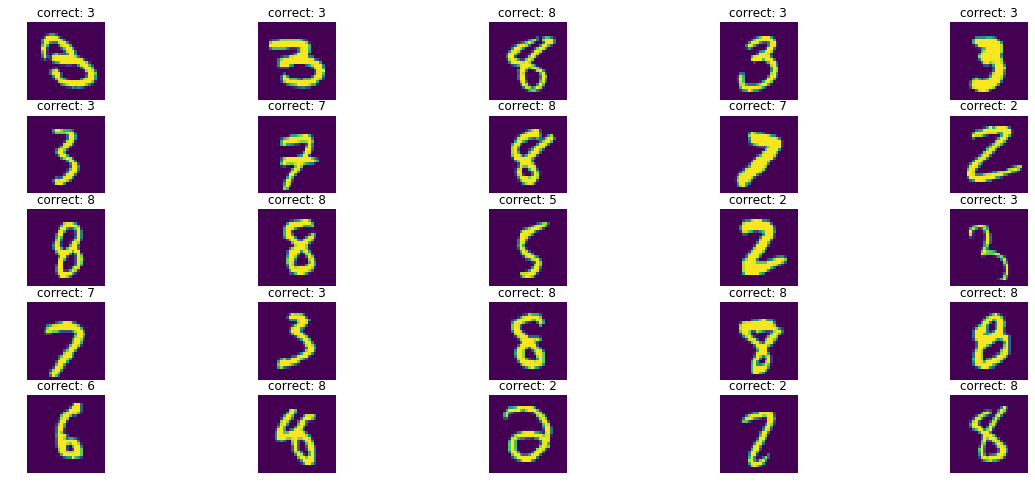

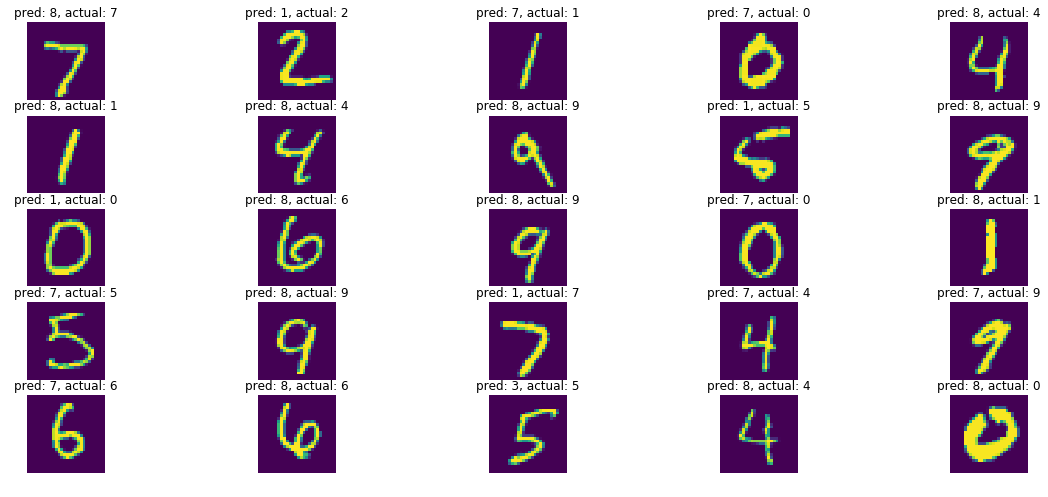

  3%|▎         | 6/235 [00:00<00:37,  6.05it/s]

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.319862


 43%|████▎     | 102/235 [00:04<00:05, 25.60it/s]

Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.363075


 87%|████████▋ | 204/235 [00:08<00:01, 26.59it/s]

Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.234461


 10%|█         | 1/10 [00:00<00:03,  2.57it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 30%|███       | 3/10 [00:00<00:02,  3.17it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 50%|█████     | 5/10 [00:00<00:01,  3.84it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 70%|███████   | 7/10 [00:01<00:00,  4.50it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])

Test set: Average loss: 0.2434, Accuracy: 9300/10000 (93%)

Saved /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/000.pt



  2%|▏         | 5/235 [00:00<00:33,  6.93it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.226420


 43%|████▎     | 102/235 [00:04<00:05, 26.09it/s]

Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.184923


 87%|████████▋ | 204/235 [00:08<00:01, 24.17it/s]

Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.138915


 10%|█         | 1/10 [00:00<00:03,  2.41it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 30%|███       | 3/10 [00:00<00:02,  3.05it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 50%|█████     | 5/10 [00:00<00:01,  3.63it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 70%|███████   | 7/10 [00:01<00:00,  4.24it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])

Test set: Average loss: 0.1648, Accuracy: 9496/10000 (95%)

Saved /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/001.pt



  2%|▏         | 5/235 [00:00<00:32,  7.13it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.146327


 45%|████▍     | 105/235 [00:04<00:05, 25.80it/s]

Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.106842


 87%|████████▋ | 204/235 [00:08<00:01, 26.03it/s]

Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.169502


 10%|█         | 1/10 [00:00<00:03,  2.47it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 30%|███       | 3/10 [00:00<00:02,  3.09it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 50%|█████     | 5/10 [00:00<00:01,  3.67it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 70%|███████   | 7/10 [00:01<00:00,  4.18it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])

Test set: Average loss: 0.1303, Accuracy: 9612/10000 (96%)

Saved /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/002.pt



  2%|▏         | 5/235 [00:00<00:31,  7.24it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.077137


 44%|████▍     | 104/235 [00:04<00:05, 25.71it/s]

Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.120776


 87%|████████▋ | 205/235 [00:08<00:01, 26.33it/s]

Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.094283


 10%|█         | 1/10 [00:00<00:03,  2.49it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 30%|███       | 3/10 [00:00<00:02,  3.08it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 50%|█████     | 5/10 [00:00<00:01,  3.71it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 70%|███████   | 7/10 [00:01<00:00,  4.33it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])

Test set: Average loss: 0.1093, Accuracy: 9678/10000 (97%)

Saved /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/003.pt



  2%|▏         | 5/235 [00:00<00:35,  6.42it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.034387


 45%|████▌     | 106/235 [00:04<00:04, 25.91it/s]

Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.053986


 86%|████████▋ | 203/235 [00:08<00:01, 25.88it/s]

Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.088810


 10%|█         | 1/10 [00:00<00:03,  2.42it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 30%|███       | 3/10 [00:00<00:02,  3.05it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 50%|█████     | 5/10 [00:00<00:01,  3.60it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 70%|███████   | 7/10 [00:01<00:00,  4.26it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])

Test set: Average loss: 0.0955, Accuracy: 9699/10000 (97%)

Saved /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/004.pt



  2%|▏         | 5/235 [00:00<00:32,  6.99it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.070871


 45%|████▌     | 106/235 [00:04<00:04, 26.66it/s]

Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.039642


 86%|████████▋ | 203/235 [00:08<00:01, 25.62it/s]

Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.067740


 10%|█         | 1/10 [00:00<00:03,  2.44it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 30%|███       | 3/10 [00:00<00:02,  3.00it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 50%|█████     | 5/10 [00:01<00:01,  3.63it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 70%|███████   | 7/10 [00:01<00:00,  4.29it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])

Test set: Average loss: 0.0826, Accuracy: 9745/10000 (97%)

Saved /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/005.pt



  2%|▏         | 5/235 [00:00<00:34,  6.63it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.042006


 45%|████▍     | 105/235 [00:04<00:05, 23.91it/s]

Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.091835


 86%|████████▌ | 202/235 [00:08<00:01, 24.90it/s]

Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.043671


 10%|█         | 1/10 [00:00<00:03,  2.40it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 30%|███       | 3/10 [00:00<00:02,  2.98it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 50%|█████     | 5/10 [00:01<00:01,  3.55it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 70%|███████   | 7/10 [00:01<00:00,  4.17it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])

Test set: Average loss: 0.0768, Accuracy: 9757/10000 (98%)

Saved /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/006.pt



  2%|▏         | 5/235 [00:00<00:34,  6.76it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.030980


 44%|████▍     | 103/235 [00:04<00:05, 24.86it/s]

Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.048118


 87%|████████▋ | 205/235 [00:08<00:01, 25.85it/s]

Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.061606


 10%|█         | 1/10 [00:00<00:03,  2.48it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 30%|███       | 3/10 [00:00<00:02,  3.05it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 50%|█████     | 5/10 [00:00<00:01,  3.67it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 70%|███████   | 7/10 [00:01<00:00,  4.33it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])

Test set: Average loss: 0.0737, Accuracy: 9770/10000 (98%)

Saved /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/007.pt



  2%|▏         | 5/235 [00:00<00:31,  7.23it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.044166


 45%|████▍     | 105/235 [00:04<00:05, 24.79it/s]

Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.041830


 87%|████████▋ | 205/235 [00:08<00:01, 26.40it/s]

Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.049128


 10%|█         | 1/10 [00:00<00:03,  2.40it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 30%|███       | 3/10 [00:00<00:02,  2.93it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 50%|█████     | 5/10 [00:01<00:01,  3.60it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 70%|███████   | 7/10 [00:01<00:00,  4.23it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])

Test set: Average loss: 0.0669, Accuracy: 9790/10000 (98%)

Saved /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/008.pt



  2%|▏         | 5/235 [00:00<00:34,  6.66it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.020412


 44%|████▍     | 104/235 [00:04<00:04, 26.21it/s]

Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.022140


 87%|████████▋ | 204/235 [00:08<00:01, 25.80it/s]

Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.046244


 10%|█         | 1/10 [00:00<00:03,  2.56it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 30%|███       | 3/10 [00:00<00:02,  3.11it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 50%|█████     | 5/10 [00:00<00:01,  3.79it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 70%|███████   | 7/10 [00:01<00:00,  4.46it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])

Test set: Average loss: 0.0650, Accuracy: 9794/10000 (98%)

Saved /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/009.pt



  2%|▏         | 5/235 [00:00<00:31,  7.24it/s]

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.036948


 44%|████▍     | 104/235 [00:04<00:05, 24.45it/s]

Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.012425


 86%|████████▋ | 203/235 [00:08<00:01, 25.16it/s]

Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.037485


 10%|█         | 1/10 [00:00<00:03,  2.59it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 30%|███       | 3/10 [00:00<00:02,  3.14it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 50%|█████     | 5/10 [00:00<00:01,  3.79it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


 70%|███████   | 7/10 [00:01<00:00,  4.41it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


100%|██████████| 10/10 [00:01<00:00,  6.23it/s]

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])

Test set: Average loss: 0.0623, Accuracy: 9800/10000 (98%)

Saved /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/010.pt

Saved /gdrive/My Drive/colab_files/homework1/mnist/checkpoints/010.pt



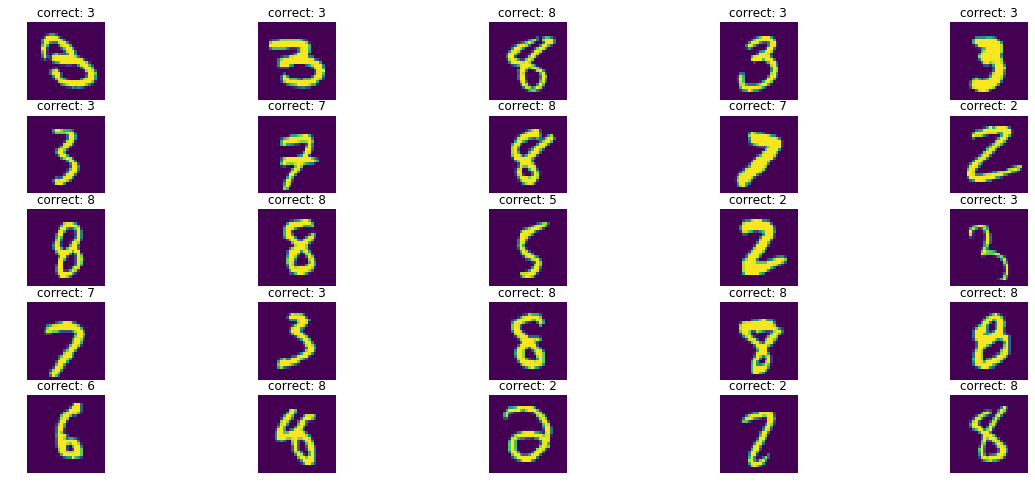

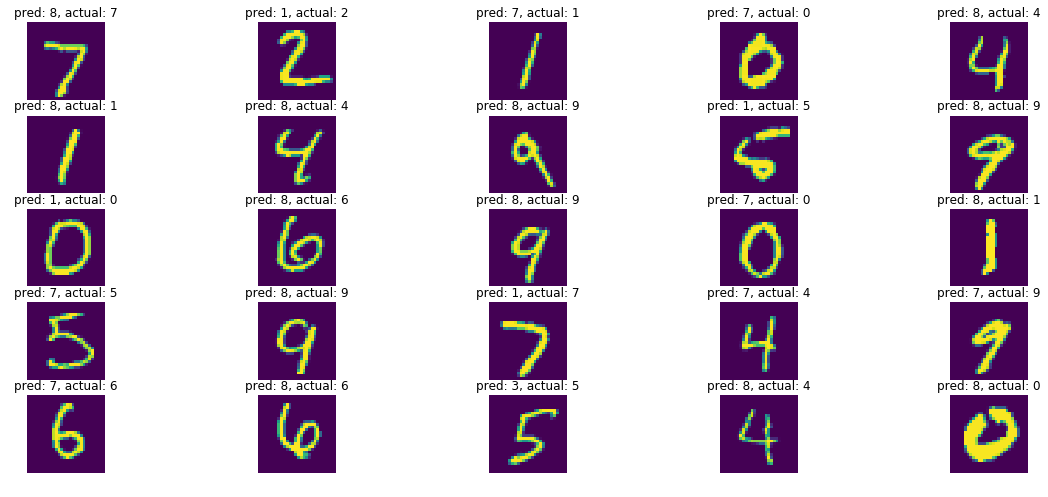

In [45]:
main()

# Download a copy for submission and put it in your repository.
File -> download .ipynb